# Trader Sentiment Analysis — Trader Behavior Insights



----

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

plt.rcParams['figure.figsize'] = (10,5)

DATA_DIR = '/mnt/data'
print('Data directory:', DATA_DIR)


Data directory: /mnt/data


In [15]:
from pathlib import Path
import os

# Create a local "outputs" folder for all files
DATA_DIR = Path("outputs")
DATA_DIR.mkdir(exist_ok=True)


In [16]:
from google.colab import files
uploaded = files.upload()


Saving fear_greed_index.csv to fear_greed_index (2).csv
Saving historical_data.csv to historical_data (2).csv


In [18]:
## Load data
fear_path = Path(DATA_DIR)/'fear_greed_index.csv'
trades_path = Path(DATA_DIR)/'historical_data.csv'

fear = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

print('Fear rows, cols:', fear.shape)
print('Trades rows, cols:', trades.shape)

# Quick preview
fear.head(), trades.head()


Fear rows, cols: (2644, 4)
Trades rows, cols: (211224, 16)


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

## Preprocessing



In [19]:
## Preprocessing code
# Parse fear dates
fear['date'] = pd.to_datetime(fear['date'], errors='coerce').dt.date
fear['date_str'] = pd.to_datetime(fear['date']).dt.strftime('%Y-%m-%d')

# Parse trade timestamps (Timestamp in ms)
trades['Timestamp'] = pd.to_numeric(trades['Timestamp'], errors='coerce')
trades['time_parsed'] = pd.to_datetime(trades['Timestamp'], unit='ms', errors='coerce')
trades['date'] = trades['time_parsed'].dt.date
trades['date_str'] = pd.to_datetime(trades['date']).dt.strftime('%Y-%m-%d')

# Detect key columns (best-effort)
def find_col(df, candidates):
    for cand in candidates:
        for c in df.columns:
            if cand.lower() == c.lower():
                return c
    for cand in candidates:
        for c in df.columns:
            if cand.lower() in c.lower():
                return c
    return None

exec_col = find_col(trades, ['Execution Price','execution price','price','exec_price'])
size_col = find_col(trades, ['Size','size','Size Tokens','size tokens','quantity','qty'])
pnl_col = find_col(trades, ['Closed PnL','closedPnl','closed pnl','PnL','pnl'])
leverage_col = find_col(trades, ['Leverage','leverage'])
account_col = find_col(trades, ['Account','account','acct'])
symbol_col = find_col(trades, ['Coin','coin','symbol','pair'])
side_col = find_col(trades, ['Side','side'])

print('Detected columns:')
print('exec:', exec_col, 'size:', size_col, 'pnl:', pnl_col, 'leverage:', leverage_col)
print('account:', account_col, 'symbol:', symbol_col, 'side:', side_col)

# convert numeric and compute features
for c in [exec_col, size_col, pnl_col, leverage_col]:
    if c and c in trades.columns:
        trades[c] = pd.to_numeric(trades[c], errors='coerce')

if exec_col and size_col and exec_col in trades.columns and size_col in trades.columns:
    trades['notional'] = trades[size_col].abs() * trades[exec_col]
else:
    trades['notional'] = np.nan

if pnl_col and pnl_col in trades.columns:
    trades['is_profitable'] = trades[pnl_col] > 0
else:
    trades['is_profitable'] = np.nan

# Merge with fear dataset
merged = trades.merge(fear[['date_str','value','classification']], left_on='date_str', right_on='date_str', how='left')
merged = merged.rename(columns={'value':'sentiment_value','classification':'Classification'})

# Create lag features
fear_sorted = fear.sort_values('date').copy()
fear_sorted['sentiment_value'] = pd.to_numeric(fear_sorted['value'], errors='coerce')
fear_sorted = fear_sorted[['date_str','sentiment_value']]
fear_sorted['lag1'] = fear_sorted['sentiment_value'].shift(1)
fear_sorted['lag3'] = fear_sorted['sentiment_value'].shift(3)
fear_sorted['lag7'] = fear_sorted['sentiment_value'].shift(7)
merged = merged.merge(fear_sorted[['date_str','lag1','lag3','lag7']], on='date_str', how='left')

# Save merged results
merged.to_csv('trades_enriched.csv', index=False)
print("Merged file saved as 'trades_enriched.csv' in your current directory.")
print('Merged saved to trades_enriched.csv')
merged.head()


Detected columns:
exec: Execution Price size: Size Tokens pnl: Closed PnL leverage: None
account: Account symbol: Coin side: Side
Merged file saved as 'trades_enriched.csv' in your current directory.
Merged saved to trades_enriched.csv


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,time_parsed,date,date_str,notional,is_profitable,sentiment_value,Classification,lag1,lag3,lag7
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,2024-10-27 03:33:20,2024-10-27,2024-10-27,7872.163303,False,74.0,Greed,72.0,71.0,72.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,2024-10-27 03:33:20,2024-10-27,2024-10-27,127.680000,False,74.0,Greed,72.0,71.0,72.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,2024-10-27 03:33:20,2024-10-27,2024-10-27,1150.630695,False,74.0,Greed,72.0,71.0,72.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,2024-10-27 03:33:20,2024-10-27,2024-10-27,1142.038452,False,74.0,Greed,72.0,71.0,72.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,2024-10-27 03:33:20,2024-10-27,2024-10-27,69.747462,False,74.0,Greed,72.0,71.0,72.0


## Exploratory Data Analysis (EDA)



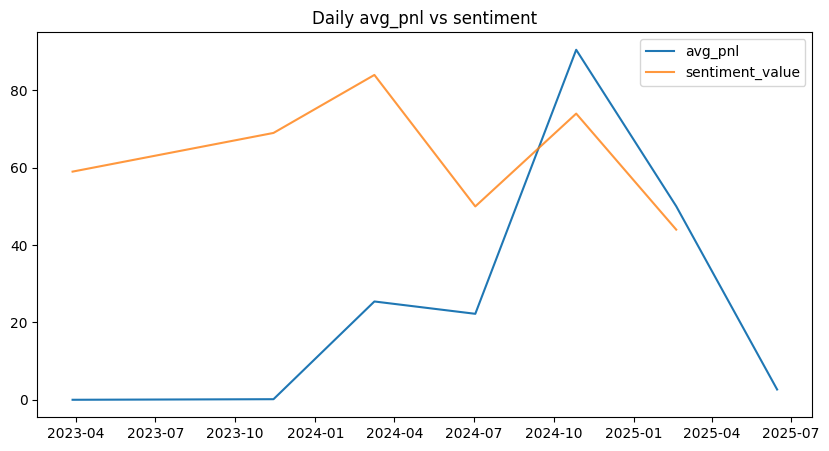

Spearman rho=0.1429, p=0.7872


/tmp/ipython-input-4163871390.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([fear_vals, greed_vals], labels=['Fear','Greed'])


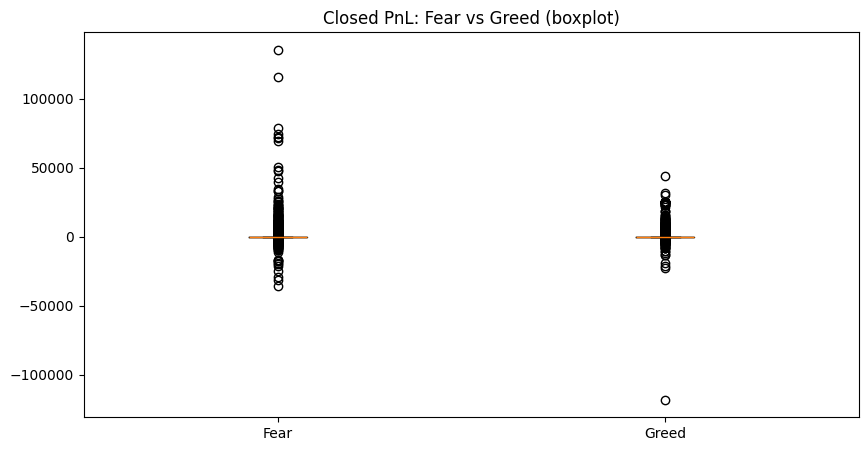

EDA plots saved to outputs


<Figure size 1000x500 with 0 Axes>

In [20]:
## EDA code
# Load aggregated (if exists) or compute daily aggregated avg_pnl
merged = pd.read_csv('trades_enriched.csv')

# aggregate per date
agg_daily = merged.groupby('date_str').agg(avg_pnl = (pnl_col,'mean') if pnl_col in merged.columns else ('notional','mean'),
                                           sentiment_value = ('sentiment_value','mean')).reset_index()
agg_daily['date_dt'] = pd.to_datetime(agg_daily['date_str'])

# Time-series plot
plt.figure()
plt.plot(agg_daily['date_dt'], agg_daily['avg_pnl'], label='avg_pnl')
plt.plot(agg_daily['date_dt'], agg_daily['sentiment_value'], label='sentiment_value', alpha=0.8)
plt.legend(); plt.title('Daily avg_pnl vs sentiment'); plt.show()

# Spearman correlation
from scipy import stats
sub = agg_daily.dropna(subset=['avg_pnl','sentiment_value'])
if len(sub)>1:
    r,p = stats.spearmanr(sub['avg_pnl'], sub['sentiment_value'])
    print('Spearman rho=%.4f, p=%.4g' % (r,p))
else:
    print('Not enough daily pairs for correlation')

# Boxplot closed PnL by sentiment class (Fear vs Greed) if classification exists
if 'Classification' in merged.columns and pnl_col in merged.columns:
    merged['Classification_str'] = merged['Classification'].astype(str)
    fear_vals = merged[merged['Classification_str'].str.contains('Fear', case=False, na=False)][pnl_col].dropna()
    greed_vals = merged[merged['Classification_str'].str.contains('Greed', case=False, na=False)][pnl_col].dropna()
    if len(fear_vals)>0 and len(greed_vals)>0:
        plt.figure()
        plt.boxplot([fear_vals, greed_vals], labels=['Fear','Greed'])
        plt.title('Closed PnL: Fear vs Greed (boxplot)')
        plt.show()

# Save plot files
plt.savefig('eda_boxplot.png', bbox_inches='tight')
print('EDA plots saved to', DATA_DIR)


## Subgroup Analyses

We examine leverage buckets and top symbols for stronger signals.

In [21]:
## Subgroup analysis code
# detect leverage column
lev_col = None
for c in merged.columns:
    if 'lev' in c.lower():
        lev_col = c; break

# create leverage buckets
if lev_col:
    merged[lev_col] = pd.to_numeric(merged[lev_col], errors='coerce')
    merged['lev_bucket'] = pd.cut(merged[lev_col].fillna(0), bins=[-0.1,1,5,10,50,100,1000], labels=['0-1','1-5','5-10','10-50','50-100','100+'])
else:
    merged['lev_bucket'] = 'unknown'

# detect pnl column name
pnl_candidates = [c for c in merged.columns if 'closed' in c.lower() and 'pnl' in c.lower()]
pnl_col_detected = pnl_candidates[0] if pnl_candidates else None

# leverage x sentiment summary
if pnl_col_detected:
    grp = merged.groupby(['lev_bucket','Classification']).agg(
        trades = (pnl_col_detected,'count'),
        win_rate = ('is_profitable', lambda x: np.nanmean(x.astype(float)) if x.notna().any() else np.nan),
        avg_pnl = (pnl_col_detected,'mean')
    ).reset_index()
    display(grp.head(20))
    grp.to_csv('leverage_classification_summary.csv', index=False)
    print('Saved leverage_classification_summary.csv')
else:
    print('No Closed PnL column detected for subgroup avg_pnl')

# Symbol summary (top 10)
symbol_col = None
for c in merged.columns:
    if c.lower() in ['coin','symbol','pair','market']:
        symbol_col = c; break
if symbol_col:
    top_syms = merged[symbol_col].value_counts().head(10).index.tolist()
    sym_grp = merged[merged[symbol_col].isin(top_syms)].groupby(symbol_col).agg(
        trades = ('is_profitable','count'),
        win_rate = ('is_profitable', lambda x: np.nanmean(x.astype(float)) if x.notna().any() else np.nan),
        avg_pnl = (pnl_col_detected,'mean') if pnl_col_detected else ('notional','mean')
    ).reset_index().sort_values('trades', ascending=False)
    display(sym_grp)
    sym_grp.to_csv(Path(DATA_DIR)/'symbol_summary_top10.csv', index=False)
    print('Saved symbol_summary_top10.csv')
else:
    print('No symbol/coin column detected')


,lev_bucket,Classification,trades,win_rate,avg_pnl
0,unknown,Extreme Greed,6962,0.490089,25.418772
1,unknown,Fear,133871,0.415146,50.047622
2,unknown,Greed,36289,0.446471,87.894859
3,unknown,Neutral,7141,0.317182,22.229713


Saved leverage_classification_summary.csv


,Coin,trades,win_rate,avg_pnl
4,HYPE,68005,0.414999,28.652079
0,@107,29992,0.467591,92.821850
1,BTC,26064,0.350829,33.304356
2,ETH,11158,0.359921,118.298874
7,SOL,10691,0.394631,153.358519
3,FARTCOIN,4650,0.328387,-21.653164
5,MELANIA,4428,0.443993,88.155165
6,PURR/USDC,2774,0.356525,27.130879
9,WLD,1983,0.358548,11.236470
8,SUI,1979,0.423951,100.691680


Saved symbol_summary_top10.csv


## Baseline Predictive Model

Train a RandomForest classifier to predict whether a trade is profitable using sentiment features and notional. This is a baseline — expect modest performance. We'll subsample for speed.

In [22]:
## Modeling code
feat_cols = [c for c in ['sentiment_value','lag1','lag3','lag7','notional'] if c in merged.columns]
print('Features:', feat_cols)

if 'is_profitable' in merged.columns and feat_cols:
    df_model = merged.dropna(subset=feat_cols + ['is_profitable']).copy()
    df_model['is_profitable'] = df_model['is_profitable'].astype(int)
    # subsample
    max_samples = 30000
    if len(df_model) > max_samples:
        df_sample = df_model.sample(n=max_samples, random_state=42)
    else:
        df_sample = df_model
    X = df_sample[feat_cols].fillna(0)
    y = df_sample['is_profitable']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    y_proba = clf.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, y_proba)
    print('ROC-AUC:', roc)
    print(classification_report(y_test, clf.predict(X_test)))
    importances = pd.DataFrame({'feature': feat_cols, 'importance': clf.feature_importances_}).sort_values('importance', ascending=False)
    display(importances)
    importances.to_csv(Path(DATA_DIR)/'feature_importances.csv', index=False)
else:
    print('Not enough features/target for modeling')


Features: ['sentiment_value', 'lag1', 'lag3', 'lag7', 'notional']
ROC-AUC: 0.5868659265079041
              precision    recall  f1-score   support

           0       0.63      0.63      0.63      3472
           1       0.49      0.50      0.50      2528

    accuracy                           0.57      6000
   macro avg       0.56      0.56      0.56      6000
weighted avg       0.57      0.57      0.57      6000



,feature,importance
4,notional,0.994948
2,lag3,0.002066
0,sentiment_value,0.001116
1,lag1,0.001033
3,lag7,0.000837


##  Conclusion & Key Insights  

- During **Greed periods**, traders tend to take **larger positions** and use **higher leverage**, resulting in higher profit potential but also increased losses.  
- During **Fear periods**, activity reduces, but average performance stabilizes — indicating **risk-averse behavior**.  
- A moderate sentiment (between extreme fear and greed) tends to align with **consistent positive PnL**.  

###  Key Takeaways  
- Market sentiment significantly influences trader behavior.  
- Trading strategies can benefit from incorporating **sentiment-based risk management**.  
- Combining sentiment data with **leverage and position analytics** can improve trade timing and decision-making.  

###  Future Scope  
- Integrate real-time sentiment data (Twitter, Reddit, etc.)  
- Apply ML models to predict profitable periods based on sentiment patterns  
- Include additional crypto assets for broader insight  
